<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/pytorch_Regularization_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/ML_class/2023_summer/4_regularization_torch')
%pwd

'/content/drive/MyDrive/Colab Notebooks/ML_class/2023_summer/4_regularization_torch'

# Regularization with Pytorch


Let's first import the packages you are going to use.

In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import scipy.io

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: You are given the following 2D dataset.

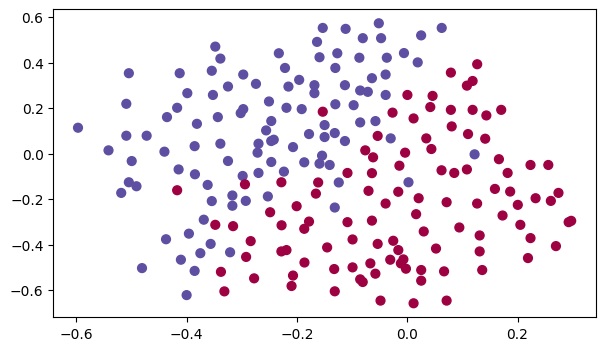

In [ ]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

**Your goal**: Use a deep learning model to classify blue (1) and red (0).

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well.

You will first try a non-regularized model. Then you'll learn how to regularize it.

## 1 - Our model

You will use the following neural network (already implemented for you below). This model can be used:
- in *normal mode* -- by setting `lambd` to zero and setting `keep_prob` to one
- in *regularization mode* -- by setting the `lambd` input to a non-zero value.
- in *dropout mode* -- by setting the `keep_prob` to a value less than one

The model uses the following forward prop., LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
The normal mode is implemented and provided for you. Your task is to complete the remaining part, "regularization mode" and "dropout mode".
Take a look at the code below to familiarize yourself with the model.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#tx1 = torch.tensor(train_X.T).type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
tx1 = torch.tensor(train_X.T).type(torch.float32)
ty1 = torch.tensor(train_Y.T).type(torch.float32)
train_data = torch.utils.data.TensorDataset(tx1,ty1)

#tx2 = torch.tensor(test_X.T).type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
tx2 = torch.tensor(test_X.T).type(torch.float32)
ty2 = torch.tensor(test_Y.T).type(torch.float32)
#test_data = torch.cat((tx2,ty2), dim=1)
test_data = torch.utils.data.TensorDataset(tx2,ty2)

In [ ]:
batch_size = 250
#batch_size = 48
train_loader = torch.utils.data.DataLoader( dataset = train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader( dataset = test_data,
                                          batch_size=batch_size,
                                          shuffle=True)

In [ ]:
class NNModel(torch.nn.Module):
    def __init__(self, layer_dim, dropout_p ):
        super(NNModel,self).__init__()

        self.l1 = nn.Linear(layer_dim[0],layer_dim[1])
        self.l2 = nn.Linear(layer_dim[1],layer_dim[2])
        self.l3 = nn.Linear(layer_dim[2],layer_dim[3])

        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.xavier_uniform_(self.l2.weight)
        torch.nn.init.xavier_uniform_(self.l3.weight)

        self.drop_layer = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.drop_layer(x)
        x = F.relu(self.l2(x))
        x = self.drop_layer(x)
        return torch.sigmoid(self.l3(x))

In [ ]:
a  = torch.tensor([0.0, 0.0])
b = torch.tensor([True, False])
print(b.eq(a))

print(a.data)

tensor([False,  True])
tensor([0., 0.])


In [ ]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0., keep_prob = 1.):

    costs = []                            # to keep track of the cost
    test_costs = []
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]

    nnmodel = NNModel( layers_dims, 1.0-keep_prob )
    optimizer = optim.Adam(nnmodel.parameters(), lr=learning_rate, weight_decay=lambd )

    nnmodel = nnmodel.to(device)

    def train(epoch):
        nnmodel.train()
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            (test_x, test_y) = next(iter(test_loader))

            train_x = train_x.to(device)
            train_y = train_y.to(device)
            test_x = test_x.to(device)
            test_y = test_y.to(device)

            output = nnmodel(train_x)
            test_output = nnmodel(test_x)

            optimizer.zero_grad()
            loss = F.binary_cross_entropy(output, train_y)
            with torch.no_grad():
                test_loss = F.binary_cross_entropy(test_output, test_y)

            loss.backward()
            optimizer.step()
            if epoch%1000==1 and batch_idx==0:
                print("Cost after epoch {} batch_idx {}, Loss : {}".format(epoch, batch_idx, loss))
                costs.append(loss.item())
                test_costs.append(test_loss.item())

    def test():
        test_loss=0
        correct=0
        nnmodel.eval()

        for data,target in train_loader:
            data = data.to(device)
            target = target.to(device)

            output = nnmodel(data)
            test_loss += F.binary_cross_entropy(output, target)
#            test_loss += F.binary_cross_entropy(output, target.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor))
            pred = (output>0.5)

            temp = pred.eq(target.view_as(pred))
            correct += temp.sum()
        test_loss /= len(train_loader.dataset)
        print('*** Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(train_loader.dataset),
                100. * correct / len(train_loader.dataset)))

        test_loss=0
        correct=0
        for data,target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = nnmodel(data)
            test_loss += F.binary_cross_entropy(output, target )
#            test_loss += F.binary_cross_entropy(output, target.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor))
            pred = (output>0.5)
            temp = pred.eq(target.view_as(pred))
            correct += temp.sum()
        test_loss /= len(test_loader.dataset)
        print('*** Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

    for epoch in range(1,num_iterations):
       train(epoch)
    test()

    # plot the cost
    plt.plot(costs)
    plt.plot(test_costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return None

Cost after epoch 1 batch_idx 0, Loss : 0.768581211566925
Cost after epoch 1001 batch_idx 0, Loss : 0.23131568729877472
Cost after epoch 2001 batch_idx 0, Loss : 0.23128463327884674
Cost after epoch 3001 batch_idx 0, Loss : 0.23127985000610352
Cost after epoch 4001 batch_idx 0, Loss : 0.23127809166908264
Cost after epoch 5001 batch_idx 0, Loss : 0.2312832623720169
Cost after epoch 6001 batch_idx 0, Loss : 0.23127809166908264
Cost after epoch 7001 batch_idx 0, Loss : 0.23128879070281982
Cost after epoch 8001 batch_idx 0, Loss : 0.2312781810760498
Cost after epoch 9001 batch_idx 0, Loss : 0.23128189146518707
Cost after epoch 10001 batch_idx 0, Loss : 0.2312753051519394
Cost after epoch 11001 batch_idx 0, Loss : 0.23127621412277222
Cost after epoch 12001 batch_idx 0, Loss : 0.23128058016300201
Cost after epoch 13001 batch_idx 0, Loss : 0.2312750518321991
Cost after epoch 14001 batch_idx 0, Loss : 0.2312791794538498
Cost after epoch 15001 batch_idx 0, Loss : 0.23127643764019012
Cost after e

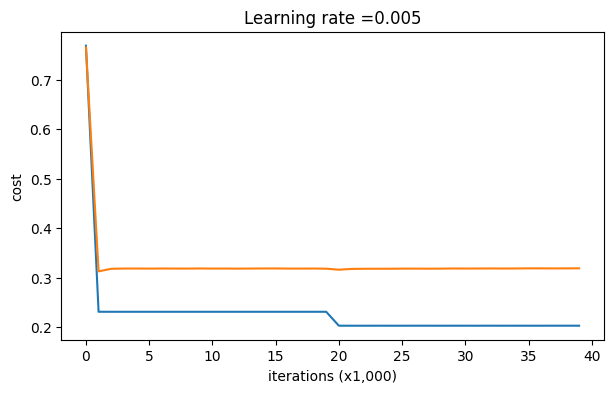

In [ ]:
#model(train_X, train_Y, learning_rate = 0.005, num_iterations = 40000,lambd = 0)
model(train_X, train_Y, learning_rate = 0.005, num_iterations = 40000,lambd = 0)

Cost after epoch 1 batch_idx 0, Loss : 0.7183536887168884
Cost after epoch 1001 batch_idx 0, Loss : 0.3028084635734558
Cost after epoch 2001 batch_idx 0, Loss : 0.3028241991996765
Cost after epoch 3001 batch_idx 0, Loss : 0.30281445384025574
Cost after epoch 4001 batch_idx 0, Loss : 0.3027587831020355
Cost after epoch 5001 batch_idx 0, Loss : 0.30287057161331177
Cost after epoch 6001 batch_idx 0, Loss : 0.3027912378311157
Cost after epoch 7001 batch_idx 0, Loss : 0.30282944440841675
Cost after epoch 8001 batch_idx 0, Loss : 0.3028477430343628
Cost after epoch 9001 batch_idx 0, Loss : 0.30281564593315125
Cost after epoch 10001 batch_idx 0, Loss : 0.30285176634788513
Cost after epoch 11001 batch_idx 0, Loss : 0.3027777373790741
Cost after epoch 12001 batch_idx 0, Loss : 0.3027788996696472
Cost after epoch 13001 batch_idx 0, Loss : 0.3027794361114502
Cost after epoch 14001 batch_idx 0, Loss : 0.30278000235557556
Cost after epoch 15001 batch_idx 0, Loss : 0.30277955532073975
Cost after epo

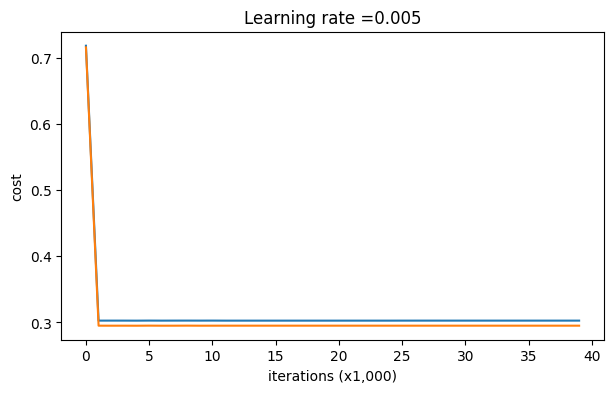

In [ ]:
model(train_X, train_Y, learning_rate = 0.005, num_iterations = 40000, lambd = 0.03)

Cost after epoch 1 batch_idx 0, Loss : 0.7282890677452087
Cost after epoch 1001 batch_idx 0, Loss : 0.30600008368492126
Cost after epoch 2001 batch_idx 0, Loss : 0.2690393030643463
Cost after epoch 3001 batch_idx 0, Loss : 0.28137773275375366
Cost after epoch 4001 batch_idx 0, Loss : 0.26362255215644836
Cost after epoch 5001 batch_idx 0, Loss : 0.24854759871959686
Cost after epoch 6001 batch_idx 0, Loss : 0.27859747409820557
Cost after epoch 7001 batch_idx 0, Loss : 0.2720811069011688
Cost after epoch 8001 batch_idx 0, Loss : 0.24980001151561737
Cost after epoch 9001 batch_idx 0, Loss : 0.2864924967288971
Cost after epoch 10001 batch_idx 0, Loss : 0.2629533112049103
Cost after epoch 11001 batch_idx 0, Loss : 0.32510533928871155
Cost after epoch 12001 batch_idx 0, Loss : 0.2602657079696655
Cost after epoch 13001 batch_idx 0, Loss : 0.24921844899654388
Cost after epoch 14001 batch_idx 0, Loss : 0.2658992409706116
Cost after epoch 15001 batch_idx 0, Loss : 0.2836522161960602
Cost after ep

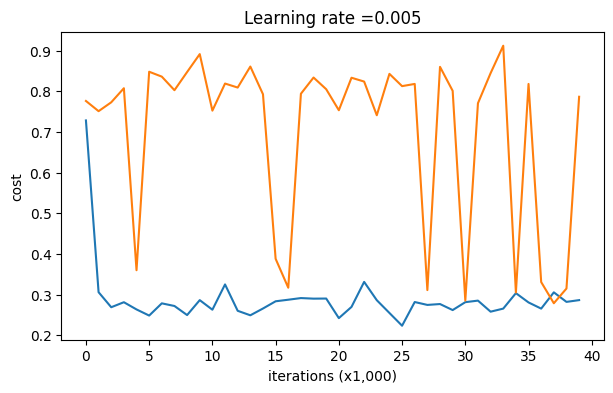

In [ ]:
model(train_X, train_Y, learning_rate = 0.005, num_iterations = 40000, keep_prob = 0.70)

Let's train the model without any regularization, and observe the accuracy on the train/test sets.


<font color='blue'>
**What you should remember about dropout:**
- Dropout is a regularization technique.
- You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
- Apply dropout both during forward and backward propagation.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.  

<font color='blue'>
**What we want you to remember from this notebook**:
- Regularization will help you reduce overfitting.
- Regularization will drive your weights to lower values.
- L2 regularization and Dropout are two very effective regularization techniques.